# PyFraug Demo Notebook
This notebook will show you how to:
 1. Load a PyFraug Dataset
 2. Apply augmentation to time series sample via `augment_one`
 3. Apply batch augmentation via `augment_batch`
 4. Build and run an `AugmentationPipeline`

### Install pyfraug using pip or maturin

In [18]:
!python3 -m pip install ./pyfraug

Processing c:\users\basur\desktop\projects\fraug\effairust2025\pyfraug
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pyfraug: filename=pyfraug-0.1.0-cp38-abi3-win_amd64.whl size=588862 sha256=f9840ba908b2b3b215859c5bdf303086bb1d9a76ffefd4c37b8fb70cb57671fc
  Stored in directory: C:\Users\basur\AppData\Local\Temp\pip-ephem-wheel-cache-39okg0mi\wheels\ab\b2\03\a8cb51619fe329c228b1885561fe240f18f2ad95b698eab587
Successfully built pyfraug
  Attempting uninstall: pyfraug
    Found existing installation: pyfraug 0.1.0
    Uninstalling pyfraug-0.1.0:
      Successfully uninstalled pyfraug-0.1.0



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3.exe -m pip install --upgrade pip


In [1]:
import time
import numpy as np
import pyfraug as pf
import pandas as pd
import matplotlib.pyplot as plt
import os

### Load a Dataset 

In [4]:
dataset_name = "Car"

csv_path = os.path.join(dataset_name, f"{dataset_name}.csv")
df = pd.read_csv(csv_path)
X = df.iloc[:, :-1].to_numpy().astype(np.float64)
y = df.iloc[:, -1].astype(str).tolist()

# Load the dataset
dataset = pf.Dataset(X, y)
labels = np.unique(dataset.labels)

print(f"Loaded dataset '{dataset_name}' with {dataset.features.shape[0]} samples, of length {dataset.features.shape[1]} and {len(labels)} unique labels: {labels}")

Loaded dataset 'Car' with 120 samples, of length 577 and 4 unique labels: ['1' '2' '3' '4']


In [6]:
# Function to plot a sample comparison
def plot_sample_comparison(original: np.ndarray,
                           augmented: np.ndarray,
                           title: str,
                           save_path: str = None):
    """
    Plot original vs augmented time series as a line chart.
    """
    plt.figure(figsize=(10,4))
    plt.plot(original, label="Original", alpha=1.0)
    plt.plot(augmented, label="Augmented", alpha=0.7)
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

### Apply Augmentation to One Time Series Sample

- Jittering : Augmenter that adds white gaussian noise of the specified standard deviation and a mean of 0

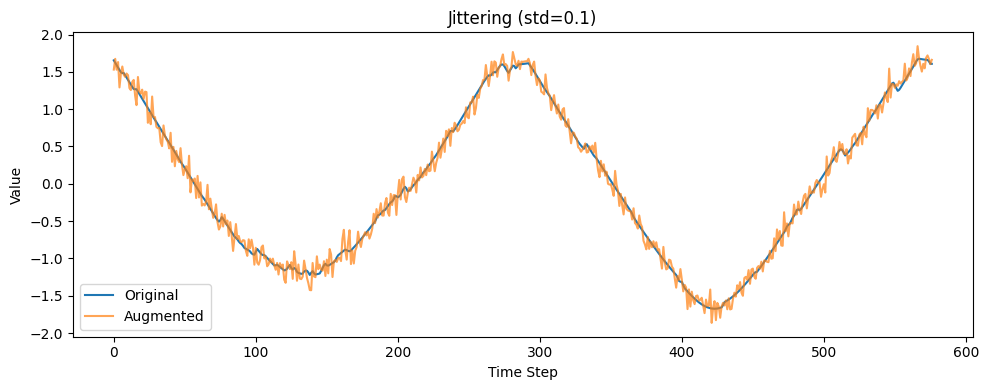

Drift

In [7]:
orig_sample = dataset.features[0] # first sample from the dataset
jitter = pf.Jittering(standard_deviation=0.1)
aug_jitter = jitter.augment_one(orig_sample)
plot_sample_comparison(orig_sample, aug_jitter, title="Jittering (std=0.1)")

pf.Drift

### Apply Augmentation to a batch or the entire dataset

- Drift : Drifts the value of a time series by a random value at each point in the series.

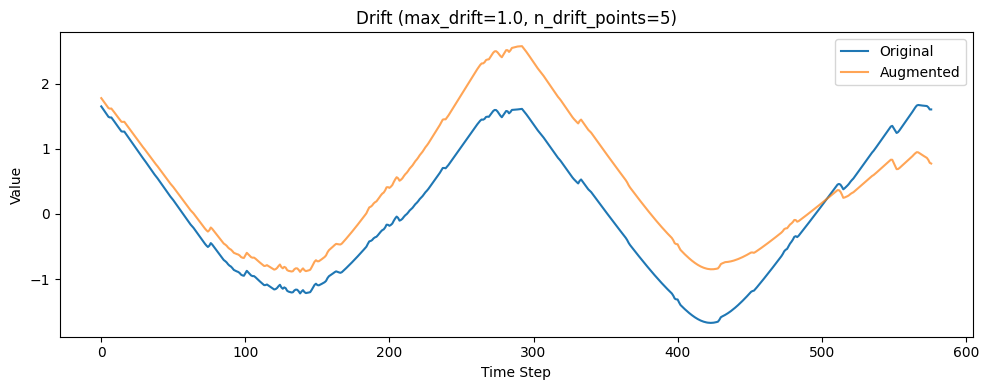

In [8]:
dataset = pf.Dataset(X.copy(), y.copy())
drift = pf.Drift(max_drift=1.0, n_drift_points=5)
drift.augment_batch(dataset, parallel=True)
aug_drift = dataset.features[0]
plot_sample_comparison(orig_sample, aug_drift, title="Drift (max_drift=1.0, n_drift_points=5)")

- Rotation : Rotates the data 180 degrees around `anchor`

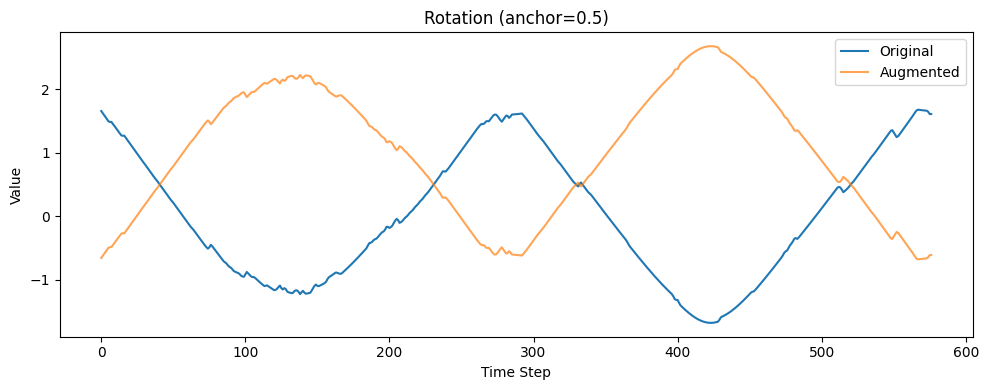

In [9]:
dataset = pf.Dataset(X.copy(), y.copy())
rotation = pf.Rotation(anchor=0.5)
rotation.augment_batch(dataset, parallel=True)
aug_rotation = dataset.features[0]
plot_sample_comparison(orig_sample, aug_rotation, title="Rotation (anchor=0.5)")

- Scaling : scales a time series with a random scalar within the range specified

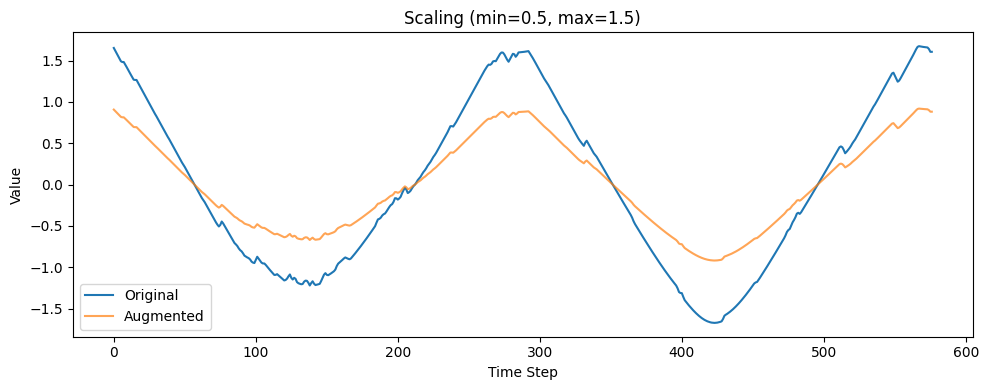

In [10]:
dataset = pf.Dataset(X.copy(), y.copy())
scaling = pf.Scaling(min=0.5, max=1.5)
scaling.augment_batch(dataset, parallel=True)
aug_scaling = dataset.features[0]
plot_sample_comparison(orig_sample, aug_scaling, title="Scaling (min=0.5, max=1.5)")

- Amplitude Phase Perturbation : Adds small Gaussian noise to each bin’s magnitude and phase

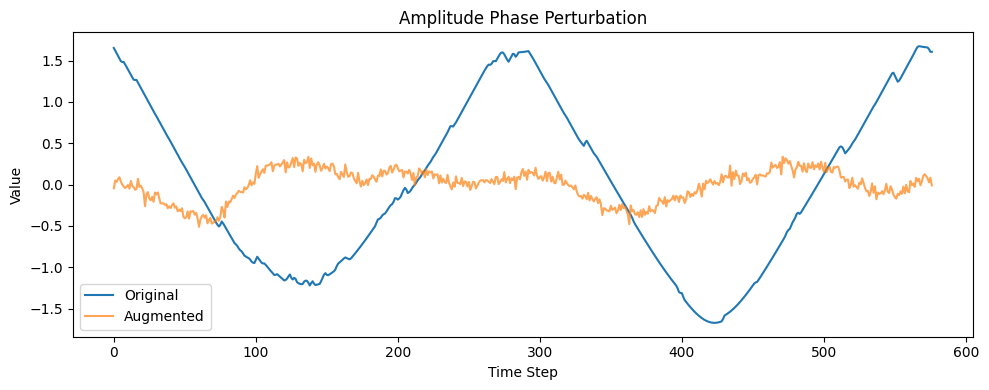

In [11]:
dataset = pf.Dataset(X.copy(), y.copy())
app = pf.AmplitudePhasePerturbation(magnitude_std= 2.0, phase_std= 1.7, is_time_domain = True)
app.augment_batch(dataset, parallel=True)
aug_app = dataset.features[0]
plot_sample_comparison(orig_sample, aug_app, title="Amplitude Phase Perturbation")

### Frequency Domain Transformations

- FFT : Fast Fourier Transform - converts a real time series to its frequency domain (complex spectrum)


In [13]:
dataset = pf.Dataset(X.copy(), y.copy())
freq_dataset = pf.Transforms.fft(dataset, parallel=True)

- IFFT : Inverse Fast Fourier Transform - reconstructs the time series from its frequency domain representation.


In [14]:
reconstrcuted_dataset = pf.Transforms.ifft(freq_dataset, parallel=True)

max_diff, all_within = pf.Transforms.compare_within_tolerance(
    dataset, reconstrcuted_dataset, 1e-6
)
print(
    f"Maximum Difference between original and reconstructed datasets: {max_diff}, all_within={all_within}"
)

Maximum Difference between original and reconstructed datasets: 2.4424906541753444e-15, all_within=True


- DCT : Discrete Cosine Transform - transforms a real time series into a sum of cosine basis functions (real coefficients).

In [15]:
dataset = pf.Dataset(X.copy(), y.copy())
freq_dataset = pf.Transforms.dct(dataset, parallel=True)

- IDCT : Inverse Discrete Cosine Transform - reconstructs the original time series from its DCT coefficients.

In [16]:
reconstrcuted_dataset = pf.Transforms.idct(freq_dataset, parallel=True)

max_diff, all_within = pf.Transforms.compare_within_tolerance(
    dataset, reconstrcuted_dataset, 1e-6
)
print(
    f"Maximum Difference between original and reconstructed datasets: {max_diff}, all_within={all_within}"
)

Maximum Difference between original and reconstructed datasets: 3.9968028886505635e-15, all_within=True


### PyFraug Pipeline

Pipeline augmentation took 0.00245489994995296 seconds


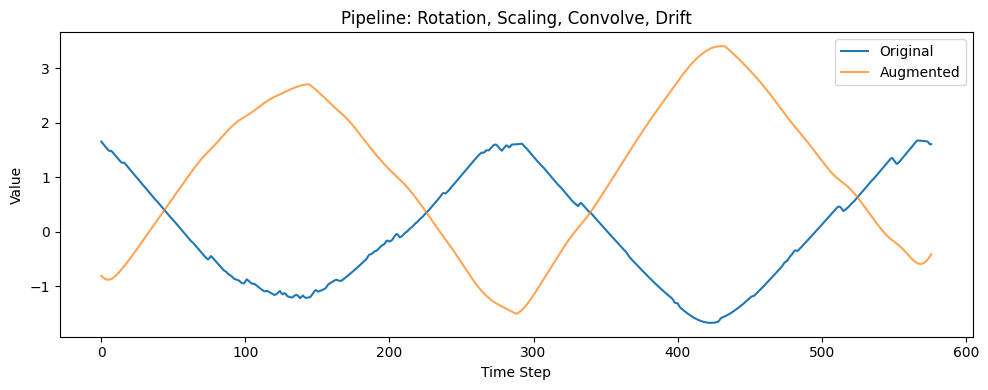

In [12]:
pipe = (
    pf.AugmentationPipeline()
    + pf.Rotation(anchor=0.5)
    + pf.Scaling(min=0.5, max=1.5)
    + pf.Convolve(pf.ConvolveWindow.Gaussian, size=31)
    + pf.Drift(max_drift=1.0, n_drift_points=5)
)
dataset = pf.Dataset(X.copy(), y.copy())
start_time = time.perf_counter()
pipe.augment_batch(dataset, parallel=True)
end_time = time.perf_counter()
print(f"Pipeline augmentation took {end_time - start_time} seconds")
aug_pipe = dataset.features[0]
plot_sample_comparison(orig_sample, aug_pipe, title="Pipeline: Rotation, Scaling, Convolve, Drift")